In [1]:
##Data from https://ssd.jpl.nasa.gov/tools/sbdb_query.html#!#results
##California Institute of Technology Jet Propulsion Laboratory. Small-Body Database Query. NASA.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_text, plot_tree
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
asteroids = pd.read_csv("asteroids.csv")
asteroids.head()

,full_name,eccentricity,inclination (deg),node (deg),perihelion arg (deg),perihelion distance (au),aphelion distance (au),data_arc,condition_code,n_obs_used,absolute magnitude,n,mean anomaly,time perihelion passage (tdb),spkid,pdes,pha_
0,433 Eros (A898 PA),0.2228,10.83,304.29,178.93,1.133,1.78,46582.0,0.0,9130,10.31,0.5598,110.78,2459802.60,20000433,433,0
1,719 Albert (A911 TB),0.5470,11.58,183.86,156.25,1.195,4.08,40483.0,0.0,2035,15.59,0.2301,10.24,2459956.02,20000719,719,0
2,887 Alinda (A918 AA),0.5707,9.40,110.42,350.48,1.061,3.88,38459.0,0.0,3025,13.83,0.2535,188.04,2460678.79,20000887,887,0
3,1036 Ganymed (A924 UB),0.5330,26.69,215.50,132.47,1.245,4.09,36005.0,0.0,9680,9.22,0.2264,231.16,2460569.53,20001036,1036,0
4,1221 Amor (1932 EA1),0.4358,11.88,171.32,26.63,1.083,2.76,32775.0,0.0,585,17.38,0.3708,49.38,2459867.32,20001221,1221,0


In [4]:
X = asteroids.iloc[:, 1:len(asteroids.columns)-3]
print(X)

       eccentricity  inclination (deg)  node (deg)  perihelion arg (deg)  \
0            0.2228              10.83      304.29                178.93   
1            0.5470              11.58      183.86                156.25   
2            0.5707               9.40      110.42                350.48   
3            0.5330              26.69      215.50                132.47   
4            0.4358              11.88      171.32                 26.63   
...             ...                ...         ...                   ...   
31844        0.5384               8.28       70.74                149.08   
31845        0.6133              28.06       78.18                 33.49   
31846        0.5238               6.11       76.69                155.86   
31847        0.2650               9.35      245.22                328.86   
31848        0.6617               4.68      182.81                234.96   

       perihelion distance (au)  aphelion distance (au)  data_arc  \
0                 

In [5]:
y = asteroids["pha_"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
##Hyperparameter Tuned Random Forest:
import warnings
import random
warnings.filterwarnings('ignore')
random.seed(123)

In [8]:
parameters = {
    "n_estimators" : np.arange(60, 120, 10), #default is 100
    "max_depth" : np.arange(50, 150, 10), #default is none
    "max_features" : ["sqrt", "log2", None], #default is sqrt
    "warm_start" : [True, False], #default False
    "min_samples_leaf" : [1, 2, 3] #default 1
}

clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = parameters,
    scoring = "accuracy",
    cv = 10
)

clf.fit(X_train, y_train)
print("Tuned Hyperparameters:", clf.best_params_)
print("Score:",clf.best_score_)

Tuned Hyperparameters: {'warm_start': False, 'n_estimators': 60, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 100}
Score: 0.9646996280179533


In [9]:
##Above code run several times; below is the max accuracy I received for all three scores 
##from one set of Random Search CV outputted hyperparameters:

randf_ = RandomForestClassifier(n_estimators=80, max_depth=60, max_features = None, warm_start = False, min_samples_leaf = 3)
randf_.fit(X_train, y_train)
predict_ = randf_.predict(X_test)

# number of correct predictions/number of predictions (accuracy)
print("RandF Score: ", randf_.score(X_test, y_test))

# number of true positives / number of all positives (true and false positives sum)
# weighted average to account for unbalanced positives/negatives in data
print("Precision Score: ", metrics.precision_score(y_test, predict_, average="weighted"))

# number of true positives / number of true positives + false negatives
print("Recall Score: ", metrics.recall_score(y_test, predict_, average="weighted"))

RandF Score:  0.967556253270539
Precision Score:  0.9664181946496824
Recall Score:  0.967556253270539


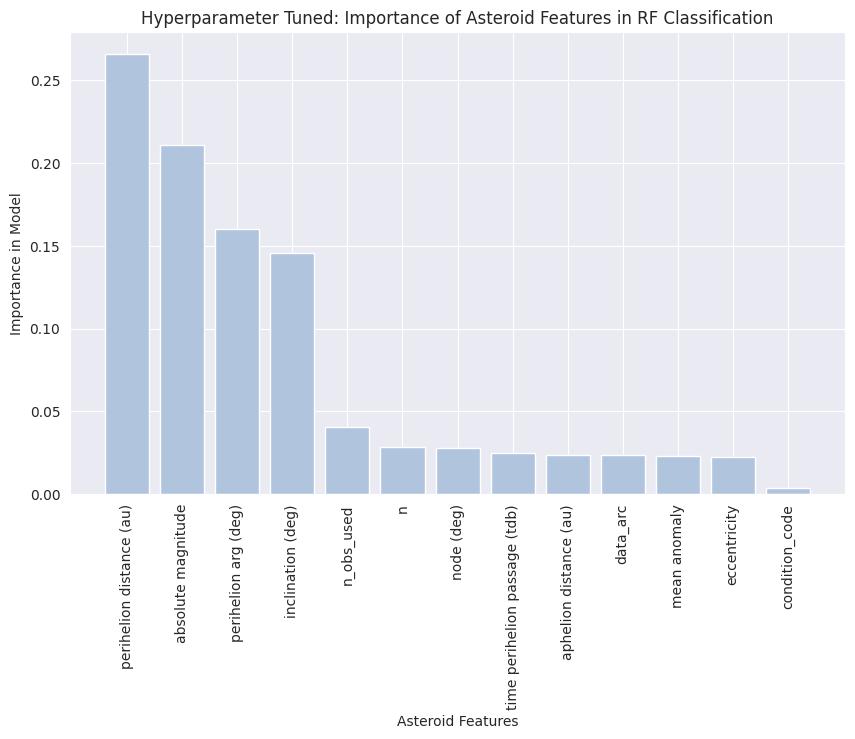

In [10]:
sns.set_style("darkgrid")
importances = randf_.feature_importances_
# [::-1] puts the sorted list in reverse order
# importances is the measured importance, features is the features
left_sorted_importances = importances[importances.argsort()[::-1]]
left_sorted_features = X_train.columns[importances.argsort()[::-1]]

plt.figure(figsize=(10, 6))
plt.bar(left_sorted_features, left_sorted_importances, color="lightsteelblue")
plt.xticks(rotation=90)
plt.xlabel('Asteroid Features')
plt.ylabel('Importance in Model')
plt.title('Hyperparameter Tuned: Importance of Asteroid Features in RF Classification')
plt.show()

<AxesSubplot: >

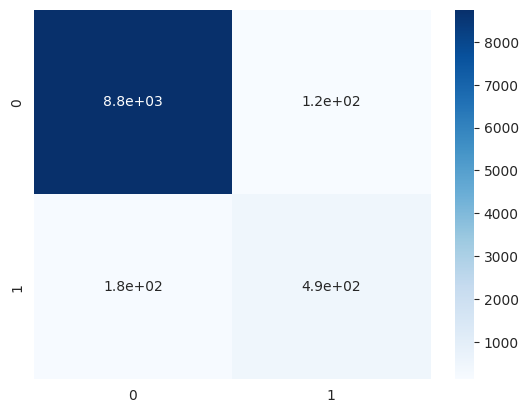

In [11]:
##top left is true positives; bottom left is false negatives; top right is false positives; bottom right
## is true negatives
matrix = metrics.confusion_matrix(y_test, predict_)
sns.heatmap(matrix, annot=True, cmap="Blues")

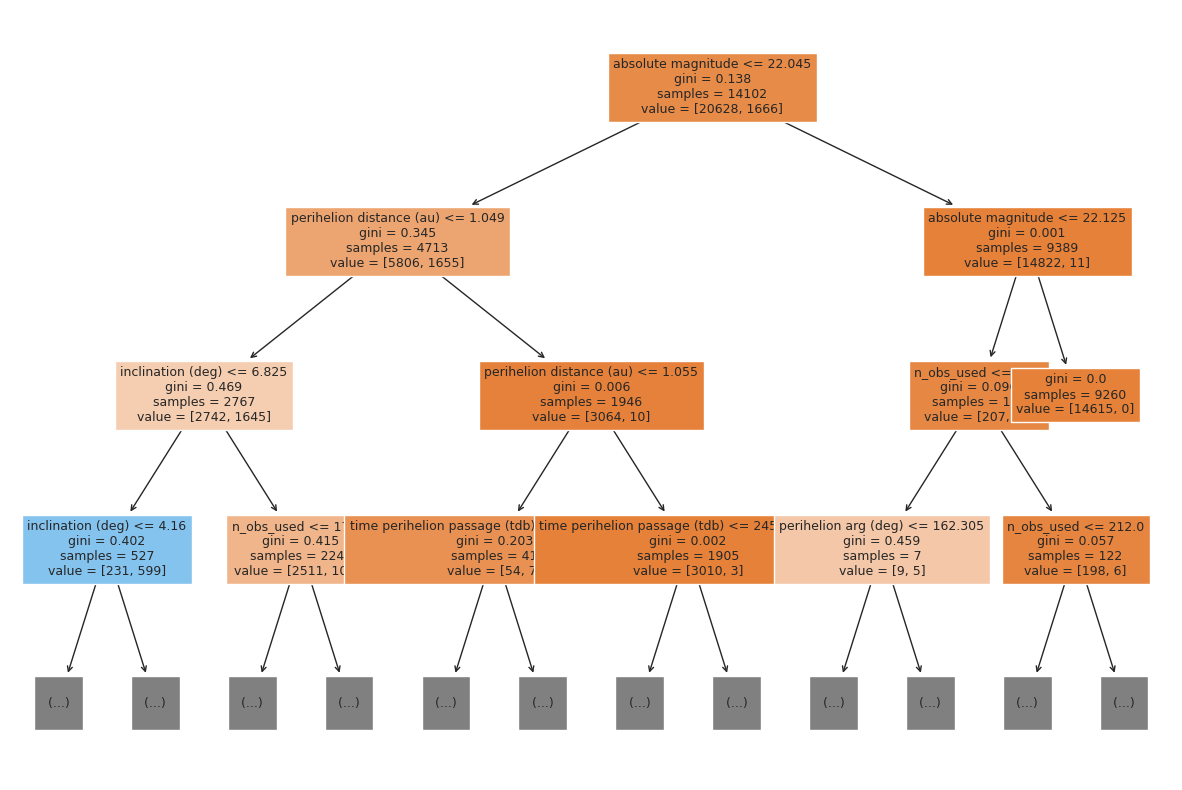

In [12]:
plt.figure(figsize=(15, 10))
tree_ = randf_.estimators_[0]
plot_tree(tree_, feature_names=list(X_train.columns), filled=True, max_depth=3, fontsize=9)
plt.show()

In [13]:
##Default Random Forest Hyperparameters (comparison, initial exploration):

In [14]:
randf = RandomForestClassifier()
fit = randf.fit(X_train, y_train)
predict_ = randf.predict(X_test)

In [15]:
# number of correct predictions/number of predictions
print("RandF Score: ", randf.score(X_test, y_test))

# number of true positives / number of all positives (true and false positives sum)
# weighted average to account for unbalanced positives/negatives in data
print("Precision Score: ", metrics.precision_score(y_test, predict_, average="weighted"))

# number of true positives / number of true positives + false negatives
print("Recall Score: ", metrics.recall_score(y_test, predict_, average="weighted"))

RandF Score:  0.9513343799058085
Precision Score:  0.9457698945684199
Recall Score:  0.9513343799058085


In [16]:
matrix = metrics.confusion_matrix(y_test, predict_)
print(matrix)

[[8790   86]
 [ 379  300]]


<AxesSubplot: >

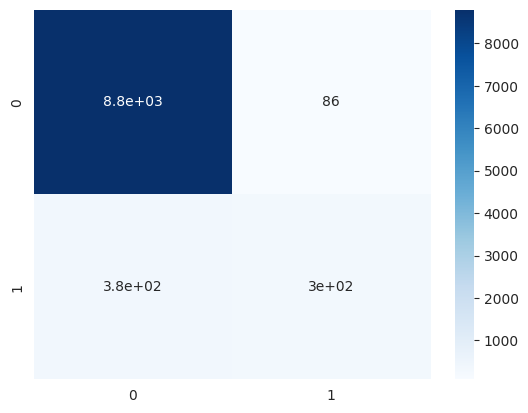

In [17]:
sns.heatmap(matrix, annot=True, cmap="Blues")

In [18]:
tree = randf.estimators_[0]
print(export_text(tree, feature_names=list(X_train.columns)))

|--- mean anomaly <= 33.83
|   |--- perihelion arg (deg) <= 76.82
|   |   |--- n_obs_used <= 162.50
|   |   |   |--- absolute magnitude <= 21.93
|   |   |   |   |--- perihelion distance (au) <= 1.03
|   |   |   |   |   |--- node (deg) <= 245.32
|   |   |   |   |   |   |--- n <= 0.26
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- n >  0.26
|   |   |   |   |   |   |   |--- data_arc <= 7.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- data_arc >  7.50
|   |   |   |   |   |   |   |   |--- n_obs_used <= 35.50
|   |   |   |   |   |   |   |   |   |--- condition_code <= 7.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- condition_code >  7.50
|   |   |   |   |   |   |   |   |   |   |--- time perihelion passage (tdb) <= 2459788.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |   |--- time perihelion passage (tdb) >  2459788.00
|   | 

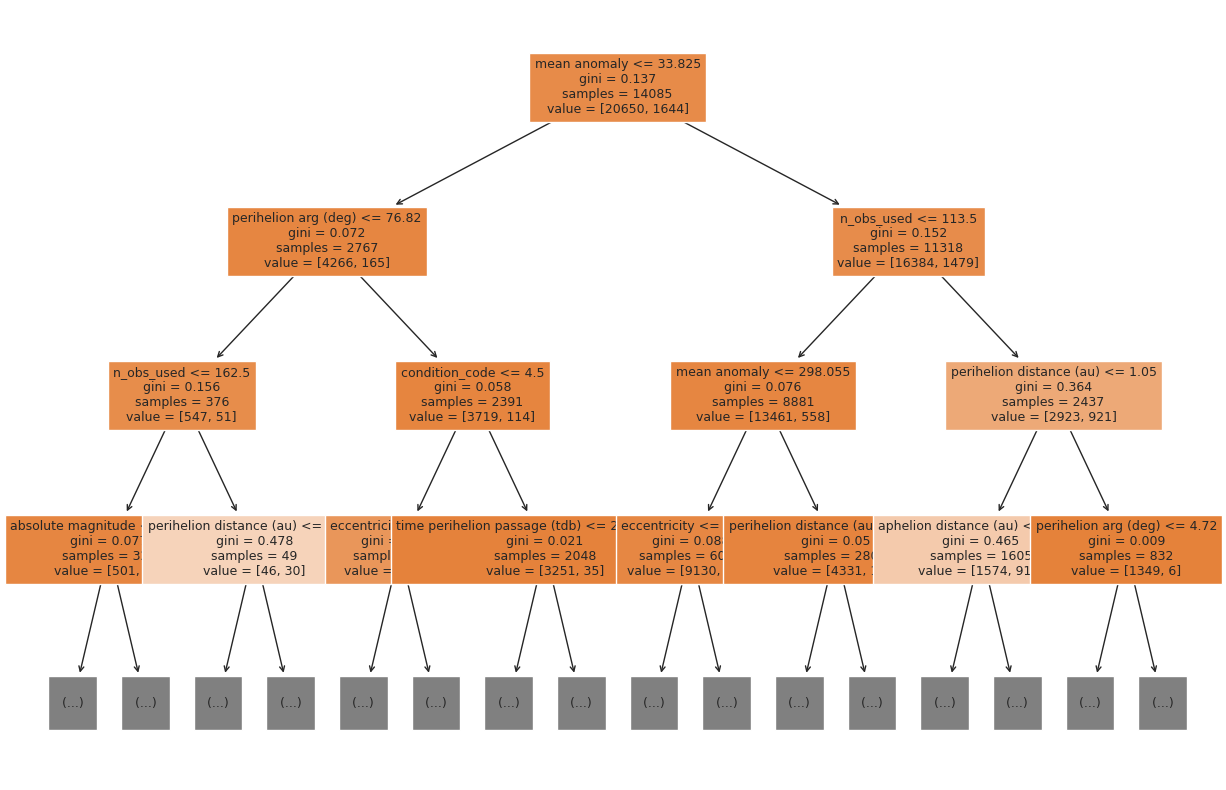

In [19]:
plt.figure(figsize=(15, 10))
plot_tree(tree, feature_names=list(X_train.columns), filled=True, max_depth=3, fontsize=9)
plt.show()

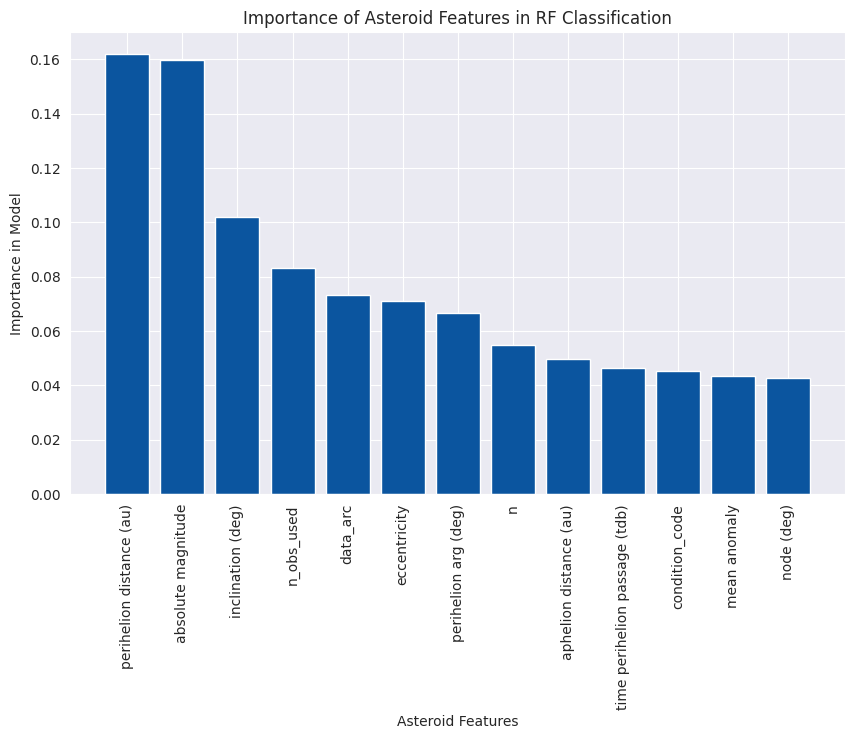

In [20]:
sns.set_style("darkgrid")
sns.set_palette("Blues_r")
importances = randf.feature_importances_
# [::-1] puts the sorted list in reverse order
# importances is the measured importance, features is the features
left_sorted_importances = importances[importances.argsort()[::-1]]
left_sorted_features = X_train.columns[importances.argsort()[::-1]]

plt.figure(figsize=(10, 6))
plt.bar(left_sorted_features, left_sorted_importances)
plt.xticks(rotation=90)
plt.xlabel('Asteroid Features')
plt.ylabel('Importance in Model')
plt.title('Importance of Asteroid Features in RF Classification')
plt.show()

In [21]:
from sklearn.ensemble import VotingClassifier
import random
from xgboost import XGBClassifier

In [22]:
parameters = {
    "subsample" : [0.25, 0.5, 0.75, 1],
    "max_depth" : [5, 6, 7, 8],
    "min_child_weight" : [0, 1, 2, 3],
    "eta" : [0.2, 0.3, 0.4, 0.5],
    "gamma" : [0, 0.1, 0.2, 0.3],
    "lambda" : [1, 1.25, 1.5, 1.75, 2],
    "alpha" : [0, 0.25, 0.5, 0.75, 1]
}
clfxgb = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions = parameters,
    scoring = "accuracy",
    cv = 10
)

In [23]:
clfxgb.fit(X_train, y_train)
print("Tuned Hyperparameters:", clfxgb.best_params_)
print("Score:",clfxgb.best_score_)

Tuned Hyperparameters: {'subsample': 1, 'min_child_weight': 1, 'max_depth': 8, 'lambda': 2, 'gamma': 0, 'eta': 0.2, 'alpha': 0.75}
Score: 0.9710690108174551


In [24]:
random.seed(123)
randf = RandomForestClassifier(n_estimators=100, max_depth=60, max_features = None, warm_start = False, min_samples_leaf = 2)
ensemble_model = VotingClassifier(estimators = [
    ("RandF", randf), ("XGB", XGBClassifier(subsample = 1, min_child_weight = 1, max_depth = 8,
                                           gamma = 0.2, eta = 0.4, reg_lambda = 1.75, alpha = 0.5))
])
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RandF',
                              RandomForestClassifier(max_depth=60,
                                                     max_features=None,
                                                     min_samples_leaf=2)),
                             ('XGB',
                              XGBClassifier(alpha=0.5, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.4,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.2,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))])

In [25]:
predict_ensemble = ensemble_model.predict(X_test)
# number of correct predictions/number of predictions
print("Model Score: ", ensemble_model.score(X_test, y_test))

# number of true positives / number of all positives (true and false positives sum)
# weighted average to account for unbalanced positives/negatives in data
print("Precision Score: ", metrics.precision_score(y_test, predict_ensemble, average="weighted"))

# number of true positives / number of true positives + false negatives
print("Recall Score: ", metrics.recall_score(y_test, predict_ensemble, average="weighted"))

Model Score:  0.9695447409733124
Precision Score:  0.9678386277376305
Recall Score:  0.9695447409733124
